# Introduction to optimization based parameter identification in Bioscrape


# What is OD data for cell growth?

Optical density (OD) can be measured to estimate the growth of cells in a liquid culture. In this notebook, we use OD data for the growth of E.coli to estimate the cell growth, cell death, and the maximum culture capacity parameters. We use a least squares minimization algorithm to find out parameter values of this model for the OD data.


# A simple cell growth model:

We use the following model for cell growth:
### $\frac{dC}{dt} = k_c \left(1 - \frac{C}{C_{max}}\right)C - dC$
here
* $k_C$: Cell growth rate
* $C_{max}$: Maximum capacity of liquid culture
* $d$: Cell death rate


### OD to count conversion
1 OD600 = 8 x 10^8 cells/mL
here, each well is 200uL, that is, 200 x 10^-6 L = 200 x 10^-6 x 10^3 mL = 0.2 mL
In 1mL there are 8 x 10^8 cells. So, in 0.2mL there are 1.6 x 10^8 cells.
So, for OD600 reading of each well, multiply that by 1.6 x 10^8 to get the total cell count. 

In [23]:
import numpy as np
import pandas as pd

od_data = pd.read_csv('od_data.csv')
list_od_data = []
for ar in od_data.iloc[:, range(2,14)]:
    df = pd.DataFrame()
    df['t'] = od_data['t']
    df['C'] = od_data[ar]*1.6e8
    list_od_data.append(df)

In [24]:
od_data

,Time,t,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
0,0:09:19,9.32,0.086,0.087,0.088,0.095,0.091,0.089,0.090,0.085,0.090,0.090,0.088,0.091
1,0:19:19,19.32,0.086,0.090,0.089,0.090,0.091,0.092,0.091,0.086,0.092,0.092,0.088,0.090
2,0:29:19,29.32,0.086,0.088,0.090,0.089,0.089,0.092,0.093,0.087,0.089,0.093,0.089,0.092
3,0:39:19,39.32,0.088,0.090,0.091,0.090,0.092,0.093,0.096,0.088,0.091,0.093,0.090,0.094
4,0:49:19,49.32,0.089,0.092,0.093,0.092,0.094,0.096,0.099,0.091,0.093,0.094,0.094,0.096
5,0:59:19,59.32,0.091,0.094,0.095,0.096,0.098,0.100,0.103,0.094,0.096,0.098,0.096,0.100
6,1:09:19,69.32,0.094,0.097,0.098,0.099,0.102,0.106,0.109,0.097,0.099,0.103,0.100,0.106
7,1:19:19,79.32,0.097,0.101,0.102,0.105,0.108,0.109,0.116,0.103,0.105,0.111,0.104,0.112
8,1:29:19,89.32,0.101,0.106,0.107,0.110,0.117,0.119,0.124,0.108,0.110,0.114,0.111,0.119
9,1:39:19,99.32,0.106,0.111,0.113,0.117,0.123,0.122,0.133,0.116,0.117,0.122,0.117,0.127


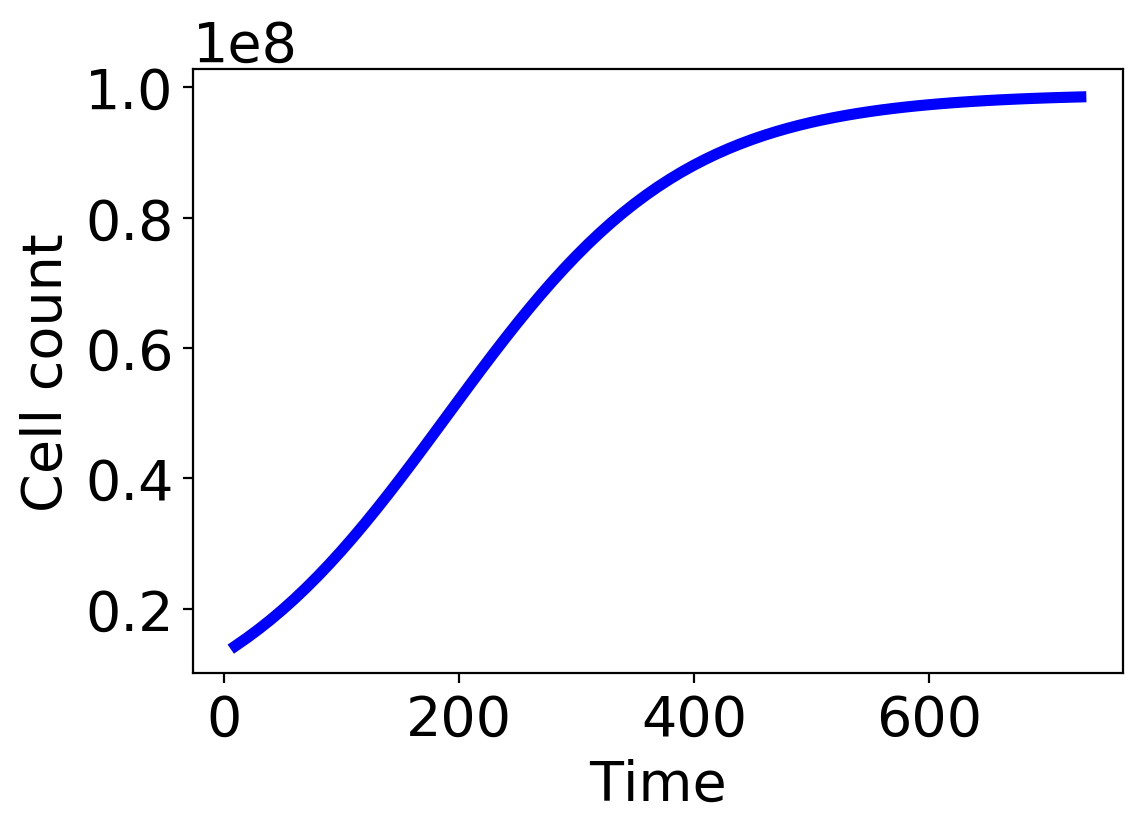

In [25]:
# Plotting code:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
import matplotlib.pyplot as plt


# Actual modeling code
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
initial_condition = np.mean(od_data.iloc[0,range(2,14)]*1.6e8)
M = Model(species = ['C'], parameters = {'k_c':0.01, 'C_max':1e8, 'd':1e-4},
          reactions = [([], ["C"], "general", {"rate":"k_c*(1- (C/C_max))*C - d*C"})],
          initial_condition_dict = {'C':initial_condition})
timepoints = np.array(od_data['t'])
sim_result = py_simulate_model(timepoints, Model = M, stochastic = False)
plt.plot(timepoints, sim_result['C'], 'b', lw = 4)
plt.xlabel('Time')
plt.ylabel('Cell count');

## Least squares fit using LMFit and Bioscrape

Successfully completed parameter identification procedure using LMFit. Parameter values and fitness reports written to lmfit_results.csv file. Check the minimizer_results object returned to further statistically evaluate the goodness of fit.


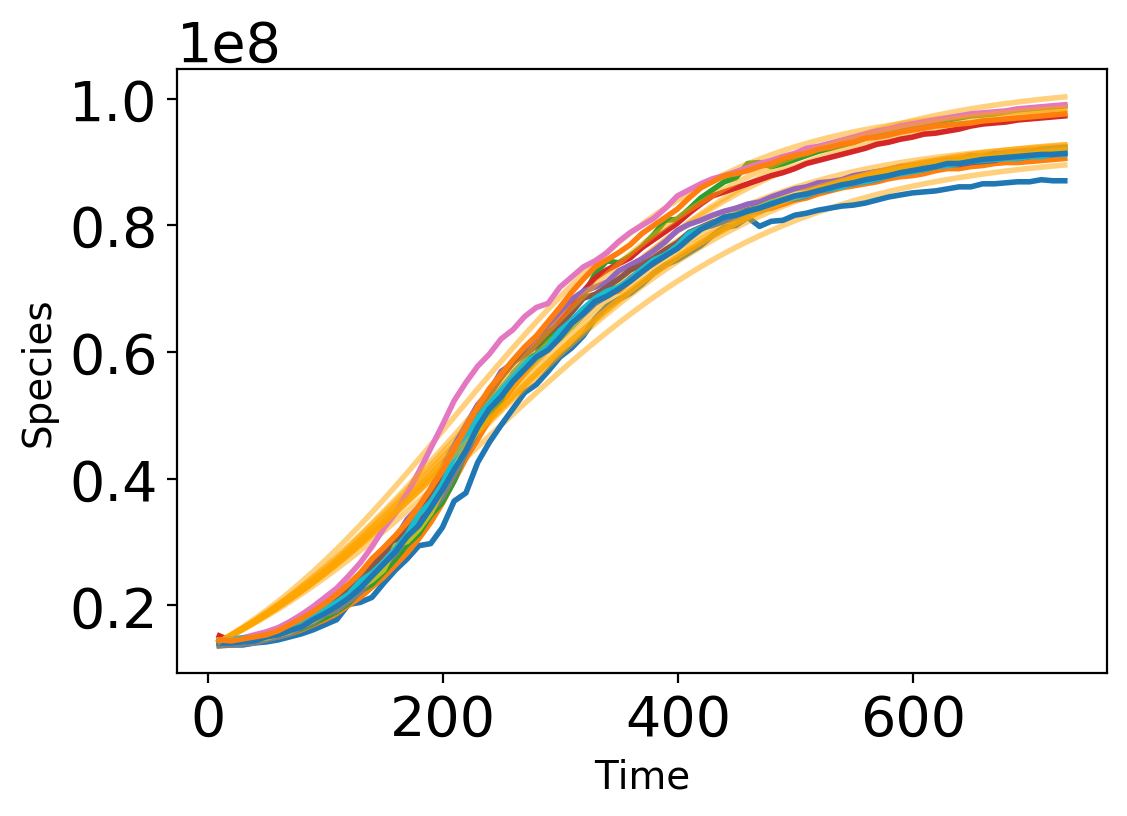

In [28]:
from bioscrape.inference import py_inference

# Create prior for parameters
# prior = {'k_c':['gaussian', 0.008, 10, 'positive'],'C_max':['gaussian', 1e8, 1e8, 'positive'], 'd' : ['gaussian', 1e-4, 10, 'positive']}
prior = {'k_c':['uniform', 0, 10],'C_max':['uniform', 1e6, 1e10], 'd' : ['uniform', 0, 5]}
minimizer_results = py_inference(Model = M, exp_data = list_od_data, measurements = ['C'], time_column = ['t'],
                                 params_to_estimate = ['k_c','C_max', 'd'], prior = prior, plot_show = True, 
                                 inference_type = 'lmfit',
                                 method = 'leastsq')


## Note: The orange trajectories above are the model simulations for each data trajectory. Check lmfit_results.csv for more information on parameter values and fitness reports.

In [27]:
minimizer_results[0]

In [30]:
from bioscrape.simulator import py_simulate_model, ModelCSimInterface
from bioscrape.types import Model

#Create a list of species names (strings)
species = ["G", "T", "X", "I"]

#create a list of parameters in the form (param_name[string], param_val[number])
params = [("ktx", 1.5), ("ktl", 10.0), ("KI", 10), ("n", 2.0), ("KR", 20), ("delta", .1)]

#create reaction tuples in the form:
#(Inputs[string list], Outputs[string list], propensity_type[string], propensity_dict {propensity_param:model_param})
rxn1 = (["G"], ["G", "T"], "proportionalhillpositive", {"d":"G", "s1":"I", "k":"ktx", "K":"KI", "n":"n"})
rxn2 = (["T"], ["T", "X"], "hillpositive", {"s1":"T", "k":"ktl", "K":"KR", "n":1}) #Notice that parameters can also take numerical values instead of being named directly
rxn3 = (["T"], [], "massaction", {"k":"delta"})
rxn4 = (["X"], [], "massaction", {"k":"delta"})

#Create a list of all reactions
rxns = [rxn1, rxn2, rxn3, rxn4]

#create an initial condition dictionary species not included in the dictionary will default to 0
x0 = {"G":1, "I":10}

#Instaniate the Model object
M = Model(species = species, parameters = params, reactions = rxns, initial_condition_dict = x0)

